In [1]:
import multiprocessing as mp
import os
import random as rn
import warnings
from glob import glob
from pathlib import Path

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import timesynth as ts
import yfinance as yf
from IPython.display import display
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, train_test_split

from run import run_cmd

seed = 42
sns.set()

def reset_seed():
    os.environ["PYTHONHASHSEED"] = str(seed)
    rn.seed(seed)
    np.random.seed(seed)

In [2]:
data_name = "nyc_energy"

Index(['timeStamp', 'demand', 'precip', 'temp'], dtype='object')
(1000, 4) 0
(1000, 2) 0


,timeStamp,demand
0,2012-01-01 00:00:00,4937.5
1,2012-01-01 01:00:00,4752.1
2,2012-01-01 02:00:00,4542.6
3,2012-01-01 03:00:00,4357.7
4,2012-01-01 04:00:00,4275.5
...,...,...
995,2012-02-11 11:00:00,5841.7
996,2012-02-11 12:00:00,5882.4
997,2012-02-11 13:00:00,5888.5
998,2012-02-11 14:00:00,5873.8


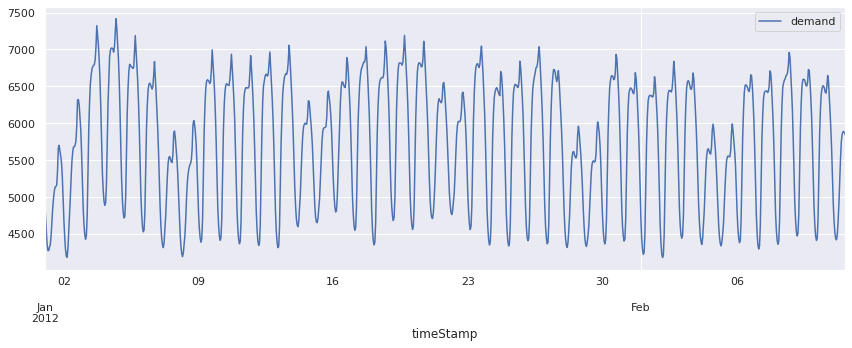

In [3]:
if data_name == "nyc_energy":
    data_path = "data/nyc_energy.csv"
    data = pd.read_csv(data_path)[:-81][:1000]
    dt, target = "timeStamp", "demand"

print(data.columns)
print(data.shape, data[target].isna().sum())

data[dt] = pd.to_datetime(data[dt])
data = data.set_index(dt)
data = data[[target]]
data = data.resample("H").mean().interpolate()
data = data.reset_index()
print(data.shape, data[target].isna().sum())

display(data)
data.plot(x=dt, y=target, figsize=(12, 5))
plt.tight_layout()
plt.show()

In [4]:
# data_fault_type = "white_noise"
# data_fault_type = "red_noise"
data_fault_type = "outliers"
n_levels = 6
target_mean = data[target].mean()
target_std = data[target].std()
# data_fault_params = dict(zip(np.arange(n_levels), target_std * np.linspace(0, 1.5, num=n_levels)))
# data_fault_params = dict(zip(np.arange(n_levels), np.linspace(0, 4, num=n_levels)))
data_fault_params = dict(zip(np.arange(n_levels), np.linspace(0, .075, num=n_levels)))
test_size = .2

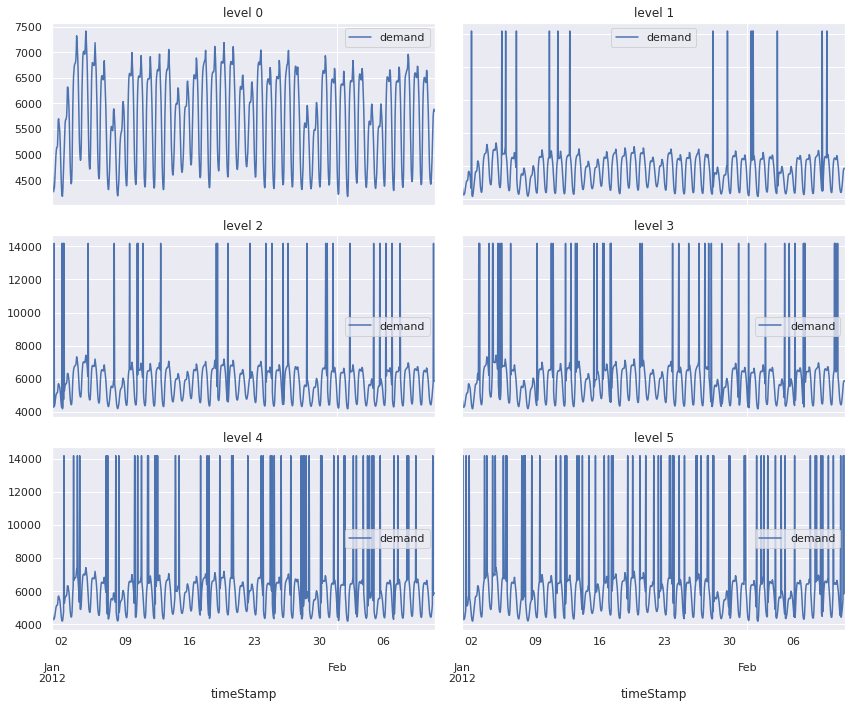

In [5]:
reset_seed()

def inject_white_noise(data, std):
    data_ = data.copy()
    data_[target] += ts.noise.GaussianNoise(std=std).sample_vectorized(data.index.values)
    return data_

def inject_red_noise(data, tau, std):
    data_ = data.copy()
    dummy_signal = ts.signals.Sinusoidal(frequency=0)
    noise_generator = ts.noise.RedNoise(std=std, tau=tau)
    timeseries = ts.TimeSeries(dummy_signal, noise_generator=noise_generator)
    data_[target] += timeseries.sample(data.index)[0]
    return data_

def inject_outliers(data, prob, mean, std):
    data_ = data.copy()
    n_train = np.round((1-test_size)*len(data)).astype(int)
    n_test = len(data)-n_train
    n_outliers = np.round(prob*len(data)).astype(int)
    n_train_outliers = np.round(prob*n_train).astype(int)
    n_test_outliers = n_outliers-n_train_outliers
    train_outlier_idxs = rn.sample(range(n_train), n_train_outliers)
    test_outlier_idxs = rn.sample(range(n_train, len(data)), n_test_outliers)
    outlier_idxs = np.concatenate((train_outlier_idxs, test_outlier_idxs))
    data_[target][outlier_idxs] = 10 * std + mean
    return data_

n_subplot_rows = n_levels//2 if n_levels % 2 == 0 else n_levels//2+1
train_dfs, test_dfs, pred_dfs = dict(), dict(), dict()

fig, axes = plt.subplots(n_subplot_rows, 2, figsize=(12, 10/3*n_subplot_rows))
for i in data_fault_params.keys():
    data_ = None
    if data_fault_type == "white_noise":
        data_ = inject_white_noise(data, data_fault_params[i])
    elif data_fault_type == "red_noise":
        data_ = inject_red_noise(data, data_fault_params[i], target_std)
    elif data_fault_type == "outliers":
        data_ = inject_outliers(data, data_fault_params[i], target_mean, target_std)

    data_.plot(x=dt, y=target, ax=axes.flatten()[i], sharex=True, sharey=True,
               title=f"level {i}")
    
    x_train, x_test, y_train, y_test = train_test_split(data_[dt].values, data_[target].values,
                                                        shuffle=False, test_size=test_size)
    train_dfs[i] = pd.DataFrame({dt: x_train, target: y_train})
    test_dfs[i] = pd.DataFrame({dt: x_test, target: y_test})
 
    train_path = f"train/{Path(data_path).stem}_{data_fault_type}_level_{i}.csv"
    if not Path(train_path).exists():
        train_dfs[i].to_csv(train_path, index=False)
plt.tight_layout()
plt.show()

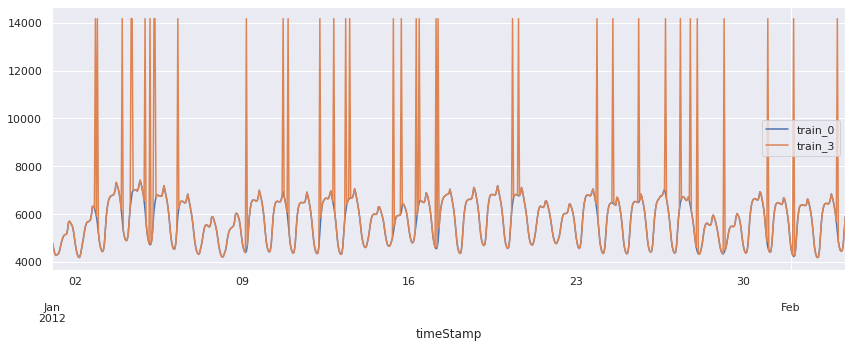

In [6]:
# df_dirty = pd.concat([train_dfs[3][target], test_dfs[5][target]], ignore_index=True)
# df = pd.DataFrame({dt: data[dt], "orig": data[target], "dirty": df_dirty})
# df.plot(x=dt, figsize=(12, 5))
# plt.tight_layout()
# plt.show()

df = pd.DataFrame({dt: train_dfs[0][dt], "train_0": train_dfs[0][target], "train_3": train_dfs[3][target]})
df.plot(x=dt, figsize=(12, 5))
plt.tight_layout()
plt.show()

In [7]:
automl_names = ["analytics-zoo", "azure_automl", "tpot_automl"]
# automl_names = ["analytics-zoo"]
n_preds = 2

In [8]:
for automl_name in automl_names:
    pred_dfs[automl_name] = dict()
    for i in range(len(data_fault_params)):
        pred_dfs[automl_name][i] = list()
        pred_paths = glob(f"pred/{Path(data_path).stem}_{data_fault_type}_level_{i}_" \
                          f"{automl_name}_*.csv")
        for pred_path in pred_paths[:n_preds]:
            df_pred = pd.read_csv(pred_path)
            df_pred.name = pred_path[-12:-4]
            df_pred[dt] = pd.to_datetime(df_pred[dt])
            pred_dfs[automl_name][i].append(df_pred)

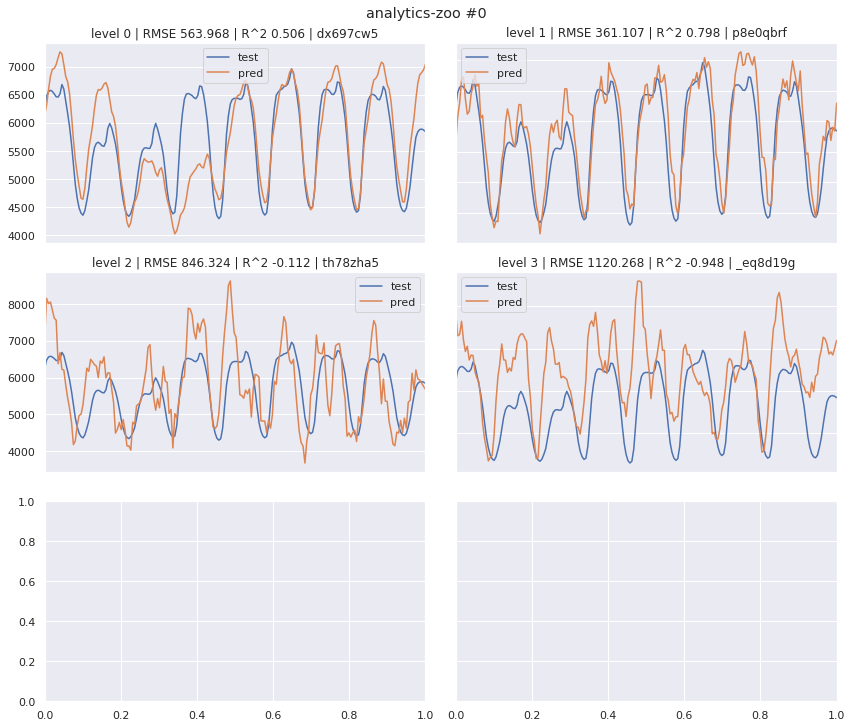

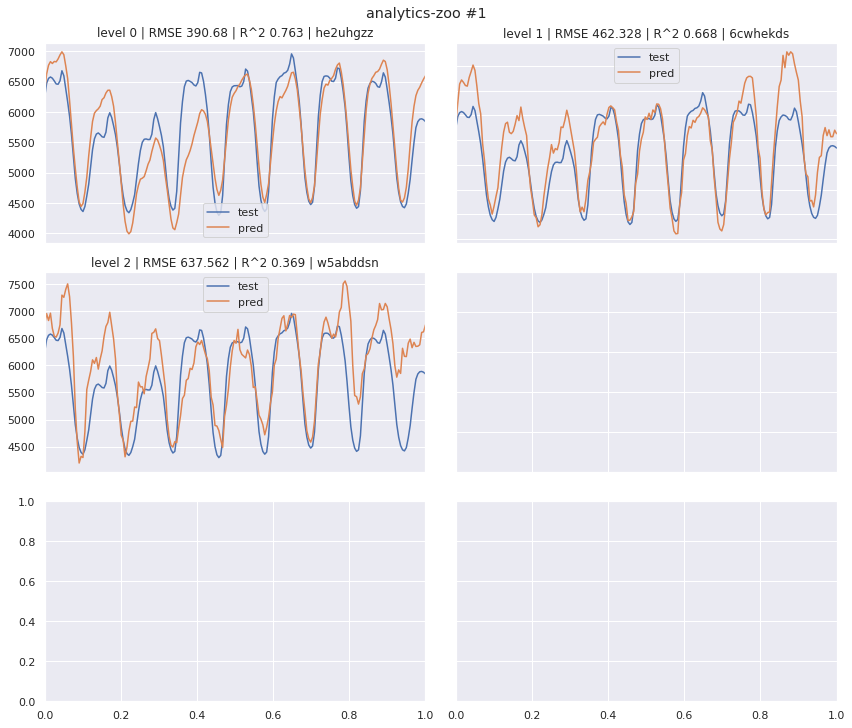

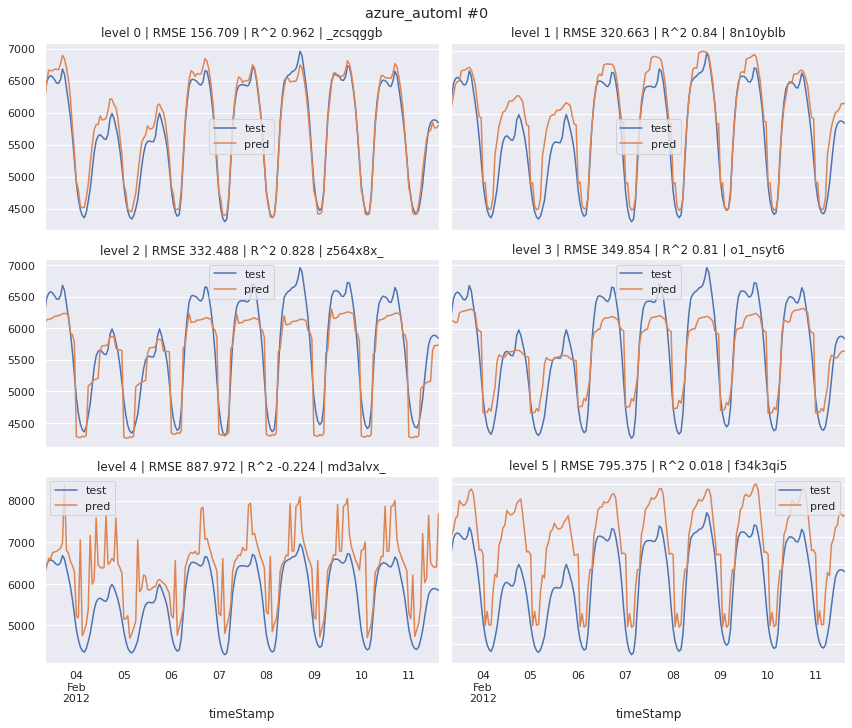

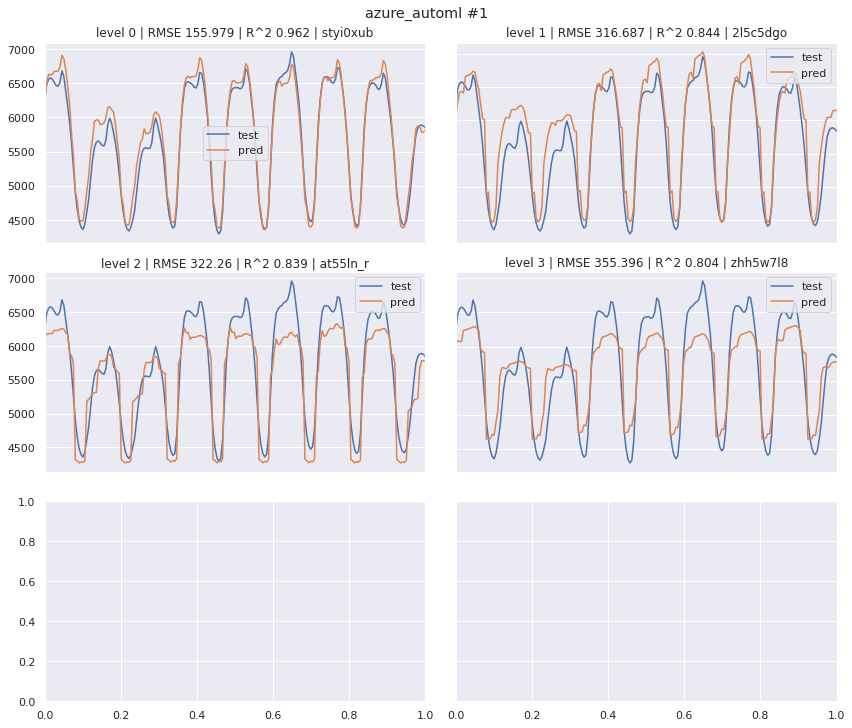

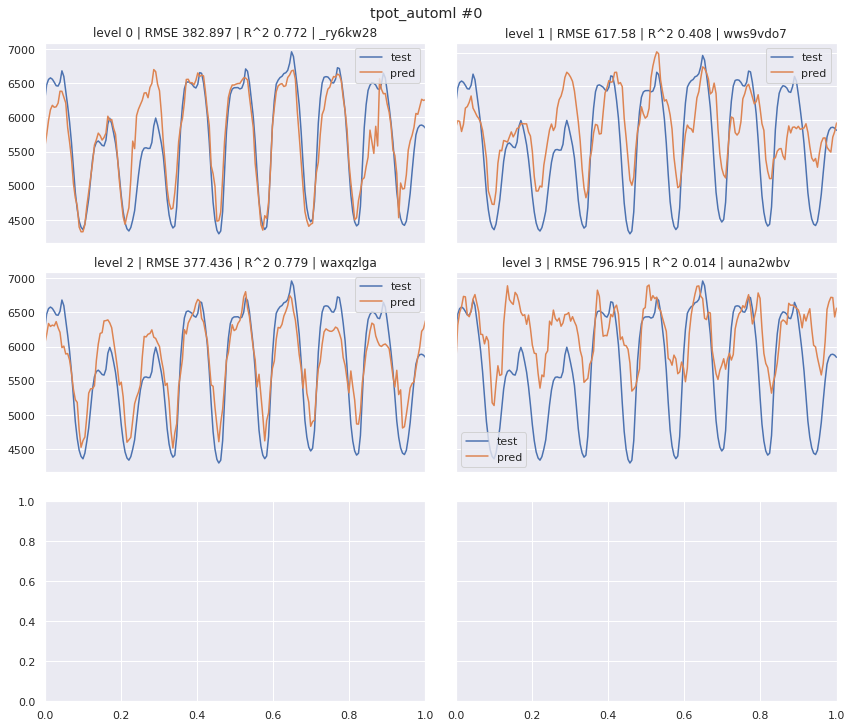

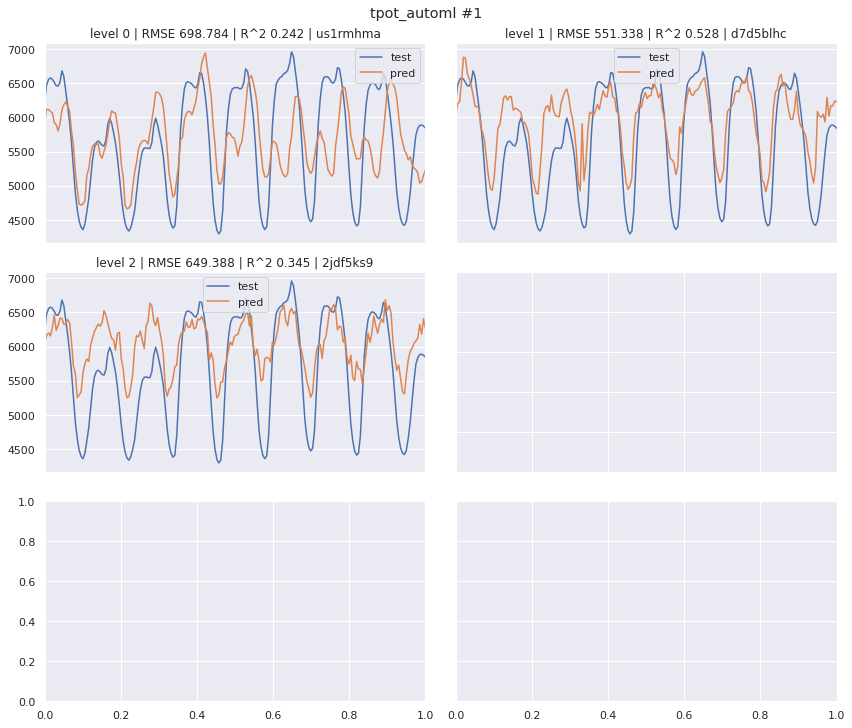

In [9]:
df_test = test_dfs[0]
metrics = []
for automl_name in automl_names:
    for i in range(n_preds):
        fig, axes = plt.subplots(n_subplot_rows, 2, figsize=(12, 10/3*n_subplot_rows))
        for j in data_fault_params.keys():
            try:
                df_pred = pred_dfs[automl_name][j][i]
            except:
                continue
            rmse = np.sqrt(mean_squared_error(df_test[target], df_pred[target]))
            r2 = r2_score(df_test[target], df_pred[target])
            metrics.append({"metric": "RMSE", "automl_name": automl_name, "level": j, "score": rmse})
            metrics.append({"metric": "R^2", "automl_name": automl_name, "level": j, "score": r2})
            df = pd.DataFrame({dt: df_test[dt], "test": df_test[target], "pred": df_pred[target]})
            df.name = automl_name
            df.plot(x=dt, ax=axes.flatten()[j], sharex=True, sharey=True,
                    title=f"level {j} | RMSE {np.round(rmse, 3)} | R^2 {np.round(r2, 3)} | " \
                          f"{df_pred.name}")
        plt.tight_layout()
        plt.suptitle(f"{automl_name} #{i}", y=1.01)
        plt.show()

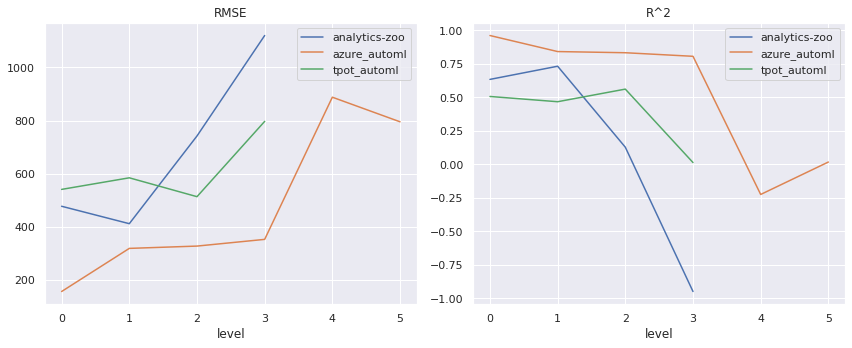

In [10]:
df_metrics = pd.DataFrame(metrics)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for ax, metric in zip(axes.flatten(), ["RMSE", "R^2"]):
    df = df_metrics[df_metrics["metric"] == metric]
    df = df.groupby(["level", "automl_name"])["score"].aggregate("mean").unstack()
    df.columns.name = None
    df.plot(ax=ax, title=metric)
plt.tight_layout()
plt.show()